In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from keras.datasets import cifar10
from keras.utils import to_categorical
 
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from keras.regularizers import l2

2024-04-08 02:41:12.075639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 02:41:12.075692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 02:41:12.077142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [3]:
print('Training data shape: ', trainX.shape)
print('Test data shape: ', testX.shape)
print('Number of classes: ', len(np.unique(trainY)))

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Number of classes:  10


In [4]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

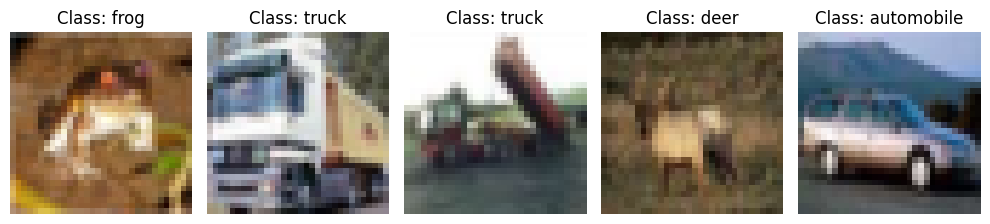

In [5]:
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1,5, i+1)
  plt.imshow(trainX[i])
  plt.title("Class: {}".format(label_names[trainY.item(i)]))
  plt.axis('off')

plt.tight_layout()
plt.show()

# Normalize the images

In [6]:
print('Train X value:', trainX[0])
print('Test X value:', testX[0])

Train X value: [[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
Test X value: [[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 

In [7]:
X_train = trainX / 255.0
X_test = testX / 255.0

In [8]:
print('Train X value after normalization:', X_train[0])
print('Test X value after normalization:', X_test[0])

Train X value after normalization: [[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  

# One hot encoding categorical variable

In [9]:
y_train = to_categorical(trainY)
y_test = to_categorical(testY)

In [10]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [11]:
model = Sequential([
# Define input layer
InputLayer(shape=(32, 32, 3)),
Conv2D(32, (3, 3), activation='relu', padding='same'),
Conv2D(32, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(64, (3, 3), activation='relu', padding='same'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dense(10, activation='softmax'),
])

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
initial_train_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('initial_modal.h5')

Epoch 1/20
  41/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1322 - loss: 2.2919

I0000 00:00:1712544085.596811   11434 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712544085.616327   11434 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3519 - loss: 1.7448

W0000 00:00:1712544094.464596   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712544095.673336   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3519 - loss: 1.7446 - val_accuracy: 0.5911 - val_loss: 1.1442
Epoch 2/20
  32/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5691 - loss: 1.2204

W0000 00:00:1712544096.835224   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6297 - loss: 1.0464 - val_accuracy: 0.6854 - val_loss: 0.8980
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7207 - loss: 0.7984 - val_accuracy: 0.7183 - val_loss: 0.7971
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7706 - loss: 0.6501 - val_accuracy: 0.7459 - val_loss: 0.7498
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8111 - loss: 0.5371 - val_accuracy: 0.7441 - val_loss: 0.7490
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8421 - loss: 0.4506 - val_accuracy: 0.7555 - val_loss: 0.7314
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8706 - loss: 0.3697 - val_accuracy: 0.7483 - val_loss: 0.7985
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8897 - loss: 0.3091 - val_accuracy: 0.7625 - val_loss: 0.8253
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9120 - loss: 0.2486 - val_accurac

In [14]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9569 - loss: 0.1223
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7392 - loss: 1.3747
Training Loss: 0.12684015929698944
Training Accuracy: 0.9559800028800964
Test Loss: 1.3425520658493042
Test Accuracy: 0.7386999726295471


In [15]:
initial_train_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

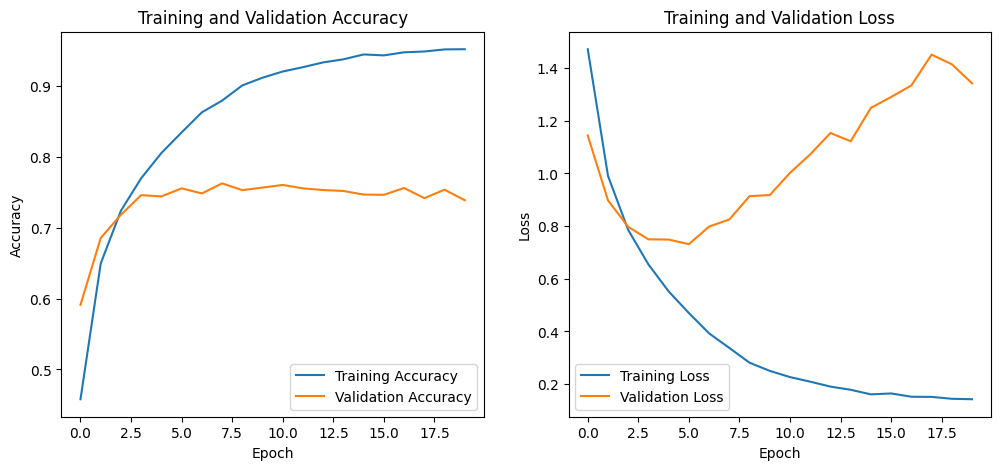

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(initial_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(initial_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(initial_train_history.history['loss'], label='Training Loss')
plt.plot(initial_train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

 98/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712544227.880796   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1712544228.787506   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


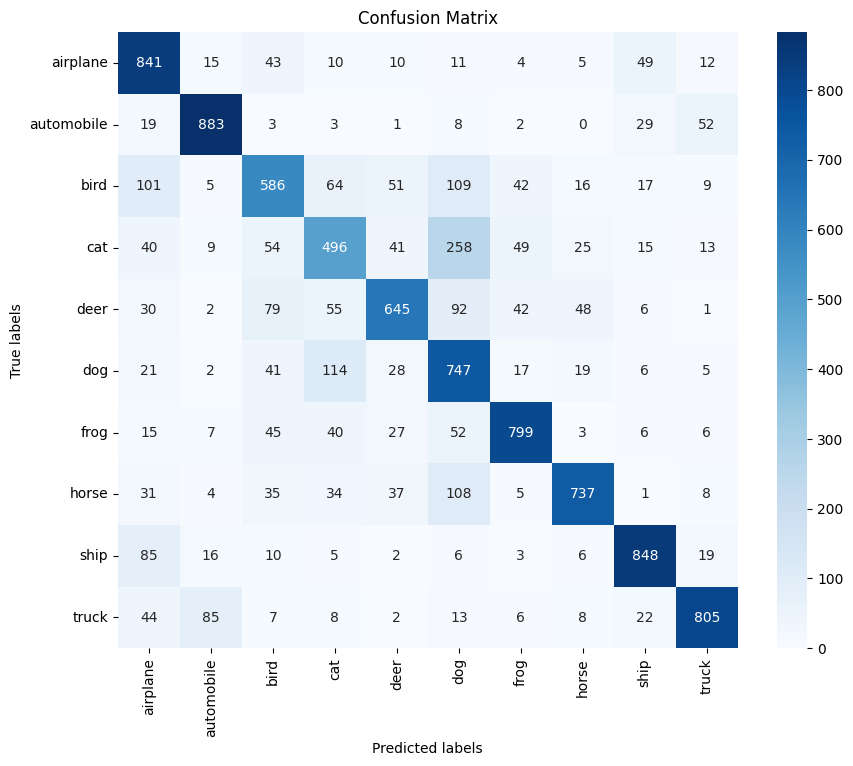

In [17]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Dropout to reduce overfitting

In [40]:
model_batch_dropout = Sequential([
InputLayer(shape=(32, 32, 3)),
Conv2D(32, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(10, activation='softmax'),
])

# compile model
model_batch_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model_batch_dropout.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
batch_dropout_train_history = model_batch_dropout.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('batch_dropout_train_modal.h5')

Epoch 1/20
  48/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1475 - loss: 2.2888

W0000 00:00:1712545113.851257   11434 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3185 - loss: 1.8303

W0000 00:00:1712545120.620005   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712545121.739401   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3185 - loss: 1.8301 - val_accuracy: 0.5701 - val_loss: 1.2035
Epoch 2/20
  49/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5117 - loss: 1.3541

W0000 00:00:1712545122.697832   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5460 - loss: 1.2761 - val_accuracy: 0.6511 - val_loss: 0.9992
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6281 - loss: 1.0580 - val_accuracy: 0.6896 - val_loss: 0.9053
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6762 - loss: 0.9276 - val_accuracy: 0.7129 - val_loss: 0.8205
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7103 - loss: 0.8372 - val_accuracy: 0.7223 - val_loss: 0.8006
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7286 - loss: 0.7682 - val_accuracy: 0.7244 - val_loss: 0.8070
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7512 - loss: 0.7115 - val_accuracy: 0.7419 - val_loss: 0.7552
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7709 - loss: 0.6585 - val_accuracy: 0.7399 - val_loss: 0.7587
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7822 - loss: 0.6197 - val_accurac

In [43]:
train_loss, train_accuracy = model_batch_dropout.evaluate(X_train, y_train)
test_loss, test_accuracy = model_batch_dropout.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9393 - loss: 0.1927
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7532 - loss: 0.8657
Training Loss: 0.1937696933746338
Training Accuracy: 0.9378200173377991
Test Loss: 0.8964269757270813
Test Accuracy: 0.7513999938964844


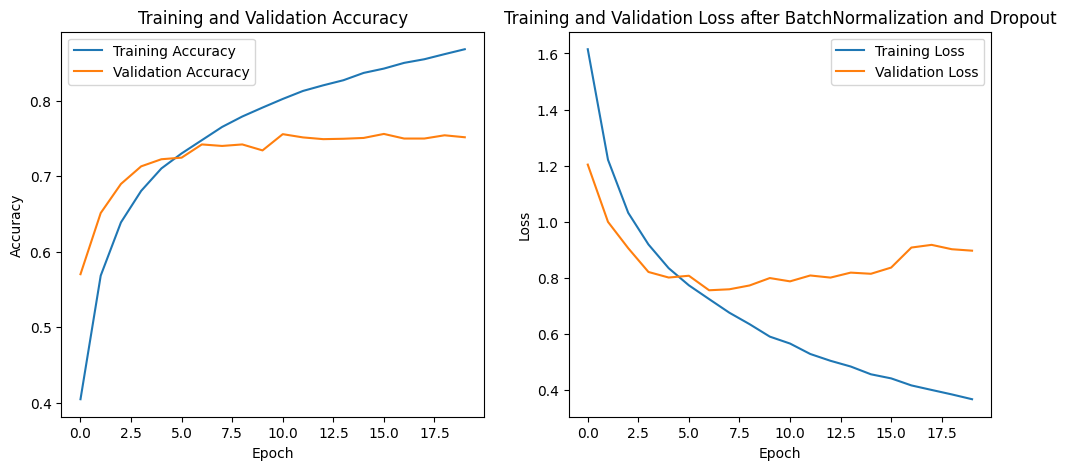

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_dropout_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(batch_dropout_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_dropout_train_history.history['loss'], label='Training Loss')
plt.plot(batch_dropout_train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after BatchNormalization and Dropout')
plt.legend()

plt.show()

102/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712545215.036818   11434 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1712545215.834224   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


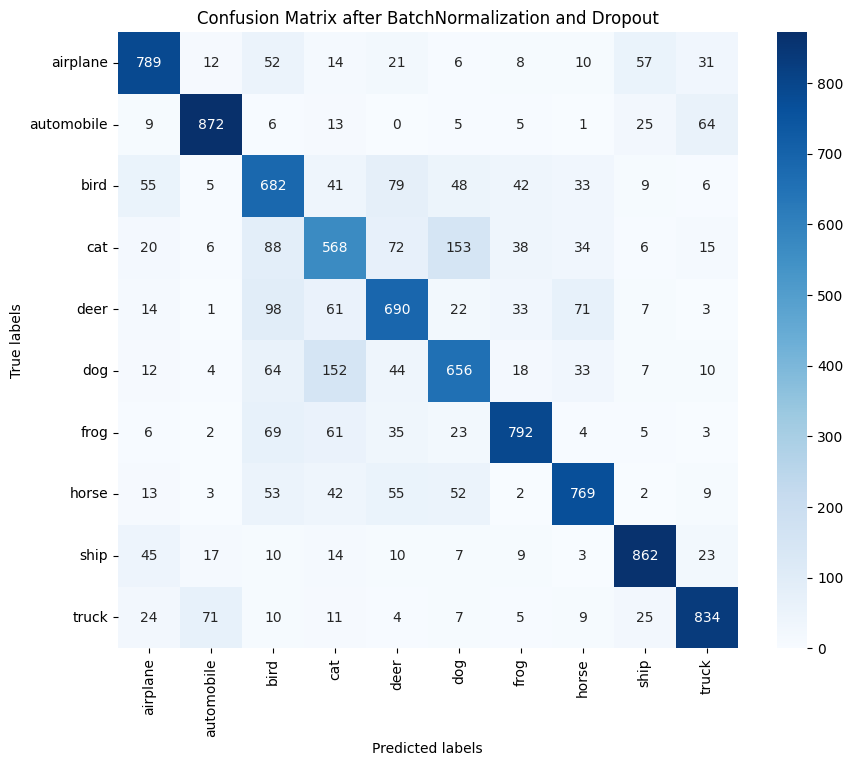

In [45]:
test_predictions = np.argmax(model_batch_dropout.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after BatchNormalization and Dropout")
plt.show()

In [46]:
cnn_with_strides = Sequential([
    InputLayer(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(250, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax'),
])

cnn_with_strides.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
cnn_with_strides.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,245,508 (4.75 MB)

 Trainable params: 1,245,508 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
cnn_with_strides_history = cnn_with_strides.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('cnn_with_strides_modal.h5')

Epoch 1/20
  42/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1126 - loss: 2.3253

W0000 00:00:1712545228.600569   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3264 - loss: 1.8113

W0000 00:00:1712545245.327247   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712545246.482291   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.3265 - loss: 1.8112 - val_accuracy: 0.5837 - val_loss: 1.1705
Epoch 2/20
  42/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5377 - loss: 1.2712

W0000 00:00:1712545247.469031   11434 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5691 - loss: 1.2021 - val_accuracy: 0.6453 - val_loss: 1.0020
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6392 - loss: 1.0299 - val_accuracy: 0.6883 - val_loss: 0.8935
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6690 - loss: 0.9414 - val_accuracy: 0.6998 - val_loss: 0.8642
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6962 - loss: 0.8569 - val_accuracy: 0.7170 - val_loss: 0.8082
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7157 - loss: 0.8154 - val_accuracy: 0.7256 - val_loss: 0.7834
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7320 - loss: 0.7634 - val_accuracy: 0.7384 - val_loss: 0.7505
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7438 - loss: 0.7245 - val_accuracy: 0.7370 - val_loss: 0.7627
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7549 - loss: 0.6946 - val_accurac

In [49]:
train_loss, train_accuracy = cnn_with_strides.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn_with_strides.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9229 - loss: 0.2593
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7704 - loss: 0.6987
Training Loss: 0.26176270842552185
Training Accuracy: 0.9204999804496765
Test Loss: 0.6982592344284058
Test Accuracy: 0.767799973487854


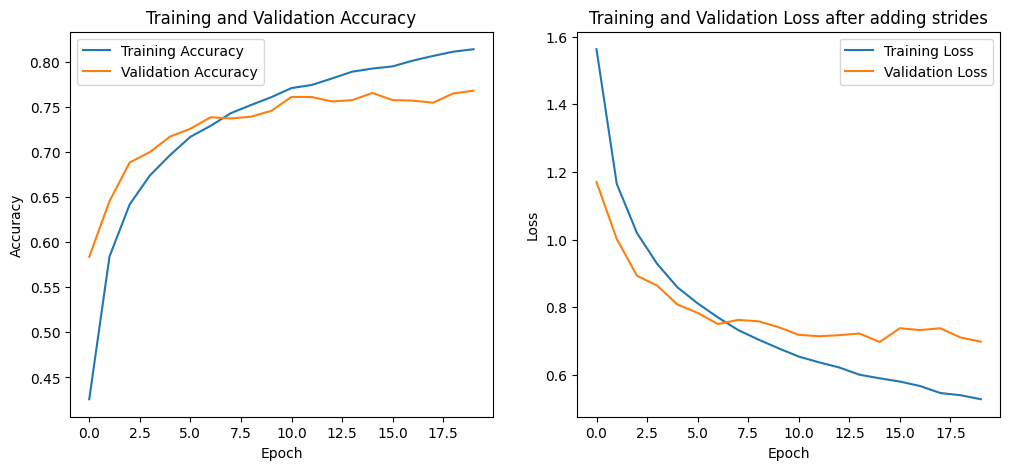

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_with_strides_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_with_strides_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after adding strides')
plt.legend()

plt.show()

 90/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712545350.324223   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1712545351.216415   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


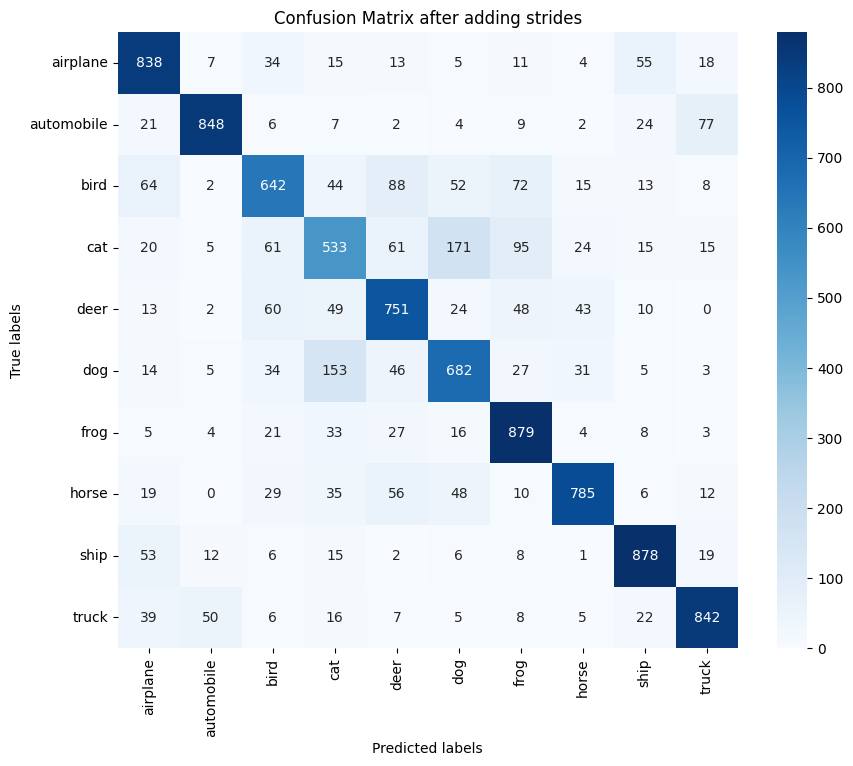

In [51]:
test_predictions = np.argmax(cnn_with_strides.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after adding strides")
plt.show()

In [52]:
cnn = Sequential([
    InputLayer(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
cnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,618 (5.20 MB)

 Trainable params: 1,362,618 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
cnn_history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('cnn_modal.h5')

Epoch 1/20
  25/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0721 - loss: 2.3134 

W0000 00:00:1712545362.858194   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2732 - loss: 1.9119

W0000 00:00:1712545376.620849   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712545377.921725   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2733 - loss: 1.9117 - val_accuracy: 0.5246 - val_loss: 1.2957
Epoch 2/20
  30/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4998 - loss: 1.3811

W0000 00:00:1712545379.164988   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5196 - loss: 1.3256 - val_accuracy: 0.6176 - val_loss: 1.0732
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5937 - loss: 1.1444 - val_accuracy: 0.6247 - val_loss: 1.0574
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6338 - loss: 1.0399 - val_accuracy: 0.6870 - val_loss: 0.8916
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6692 - loss: 0.9424 - val_accuracy: 0.6899 - val_loss: 0.8763
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6895 - loss: 0.8923 - val_accuracy: 0.7168 - val_loss: 0.8256
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7077 - loss: 0.8429 - val_accuracy: 0.7010 - val_loss: 0.8729
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7276 - loss: 0.7897 - val_accuracy: 0.7239 - val_loss: 0.7962
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7378 - loss: 0.7548 - val_accurac

In [55]:
train_loss, train_accuracy = cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8736 - loss: 0.3549
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7775 - loss: 0.6771
Training Loss: 0.3538358211517334
Training Accuracy: 0.8738800287246704
Test Loss: 0.6870158910751343
Test Accuracy: 0.7782999873161316


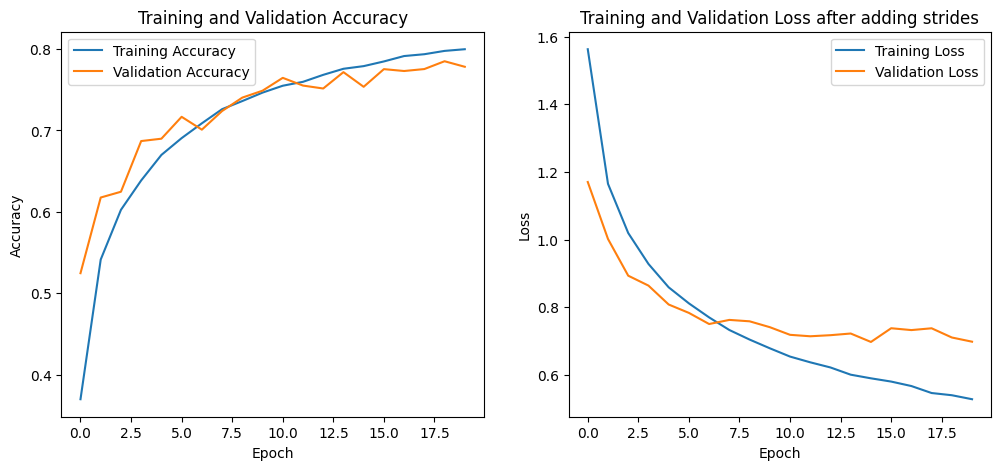

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after adding strides')
plt.legend()

plt.show()

In [62]:
cnn = Sequential([
  InputLayer(shape=(32, 32, 3)),
  Conv2D(32, (3, 3), activation='relu', padding='same'),  
  Conv2D(32, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.25), 
  Conv2D(64, (3, 3), activation='relu', padding='same'),  
  Conv2D(64, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.25),  
  Conv2D(128, (3, 3), activation='relu', padding='same'),  
  Conv2D(128, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Flatten(),
  Dense(256, activation='relu'),  
  Dropout(0.5), 
  Dense(10, activation='softmax'),
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
 17/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1052 - loss: 2.2957 

W0000 00:00:1712546710.938841   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2849 - loss: 1.9082

W0000 00:00:1712546721.740036   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712546722.776758   11435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2851 - loss: 1.9079 - val_accuracy: 0.5108 - val_loss: 1.3452
Epoch 2/100
 17/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4709 - loss: 1.4648

W0000 00:00:1712546723.562727   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5305 - loss: 1.3024 - val_accuracy: 0.5995 - val_loss: 1.1199
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6087 - loss: 1.0978 - val_accuracy: 0.6424 - val_loss: 0.9971
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6517 - loss: 0.9776 - val_accuracy: 0.6919 - val_loss: 0.8675
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6900 - loss: 0.8944 - val_accuracy: 0.7293 - val_loss: 0.7708
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7095 - loss: 0.8259 - val_accuracy: 0.7517 - val_loss: 0.7233
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7296 - loss: 0.7688 - val_accuracy: 0.7519 - val_loss: 0.7173
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7455 - loss: 0.7239 - val_accuracy: 0.7496 - val_loss: 0.7219
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7627 - loss: 0.6881 - val_accuracy: 0.7697

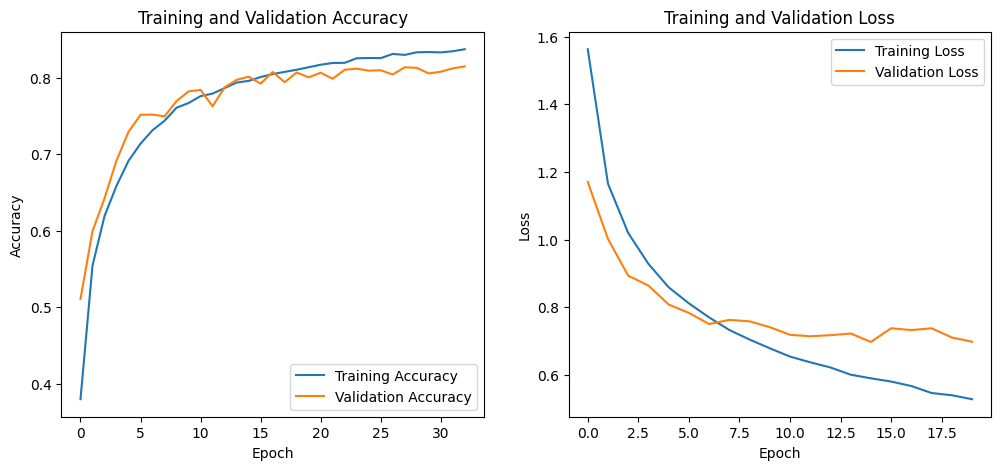

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

 95/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712546891.939647   11432 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1712546892.774299   11433 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


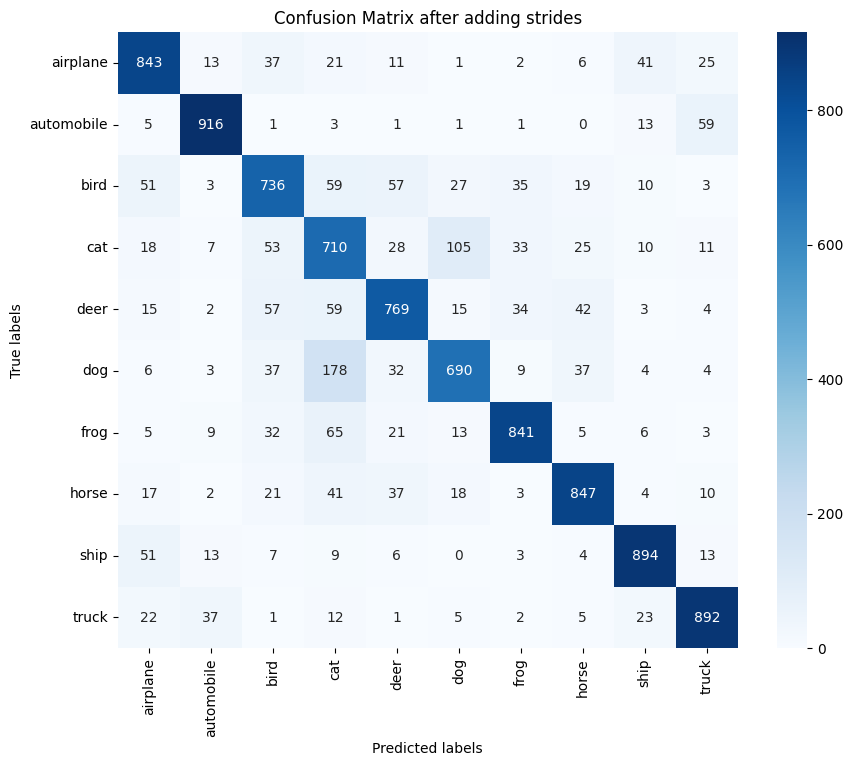

In [64]:
test_predictions = np.argmax(cnn.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after adding strides")
plt.show()